# LSTM emotion recognizer

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

In [ ]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import modules and set random seeds.

In [ ]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [ ]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [ ]:
from datasets import load_dataset
emotions = load_dataset('emotion', trust_remote_code=True)
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print('Maximum text length: {}'.format(max_textlen))

Maximum text length: 66


Create the training and test datasets.

In [ ]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_label = tf.keras.utils.to_categorical(emotions['train']['label'], 6)

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_label = tf.keras.utils.to_categorical(emotions['validation']['label'], 6)

emotion_labels = emotions['train'].features['label'].names

In [ ]:
train_text[0]

array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [ ]:
train_label[0]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

Define the bidirectional LSTM model.

In [ ]:
lstm_model = models.Sequential(name='Bidirectional_LSTM_classifier')
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, input_shape=(None,),
                                name='text_embedding'))
lstm_model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True),
                                    name='bidirectional_LSTM1'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=False),
                                    name='bidirectional_LSTMs'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(1024, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))
lstm_model.summary()

Model: "Bidirectional_LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 bidirectional_LSTM1 (Bidir  (None, None, 1024)        4198400   
 ectional)                                                       
                                                                 
 dropout1 (Dropout)          (None, None, 1024)        0         
                                                                 
 bidirectional_LSTMs (Bidir  (None, 512)               2623488   
 ectional)                                                       
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 feedforward (Dense)         (None, 1

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [ ]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [ ]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=16, epochs=8)

Epoch 1/8
1000/1000 [==============================] - 90s 74ms/step - loss: 1.3435 - acc: 0.4604 - val_loss: 0.7824 - val_acc: 0.7080
Epoch 2/8
1000/1000 [==============================] - 64s 64ms/step - loss: 0.5445 - acc: 0.7911 - val_loss: 0.4533 - val_acc: 0.8495
Epoch 3/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.2727 - acc: 0.9056 - val_loss: 0.3673 - val_acc: 0.8735
Epoch 4/8
1000/1000 [==============================] - 65s 65ms/step - loss: 0.1669 - acc: 0.9416 - val_loss: 0.3692 - val_acc: 0.8810
Epoch 5/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.1232 - acc: 0.9571 - val_loss: 0.3903 - val_acc: 0.8875
Epoch 6/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0944 - acc: 0.9671 - val_loss: 0.3405 - val_acc: 0.8980
Epoch 7/8
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0747 - acc: 0.9758 - val_loss: 0.3530 - val_acc: 0.8970
Epoch 8/8
1000/1000 [==============================] - 

Plot charts for the accuracy and loss values.

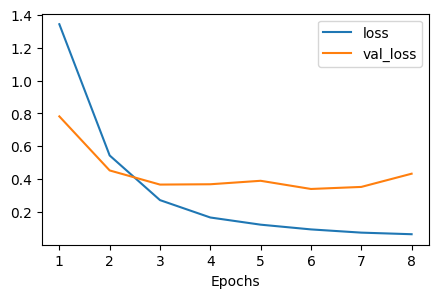

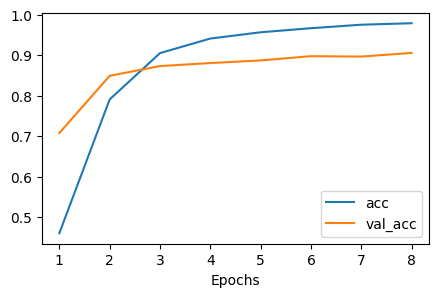

In [ ]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

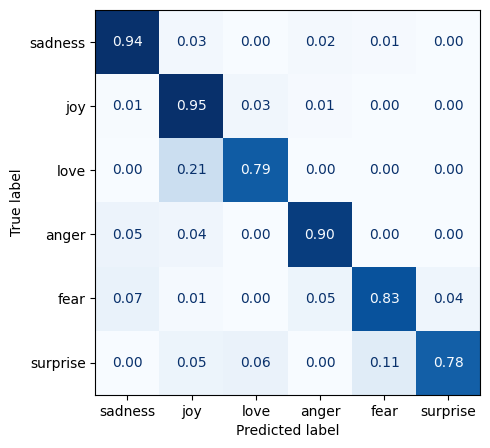

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = lstm_model.predict(test_text, verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

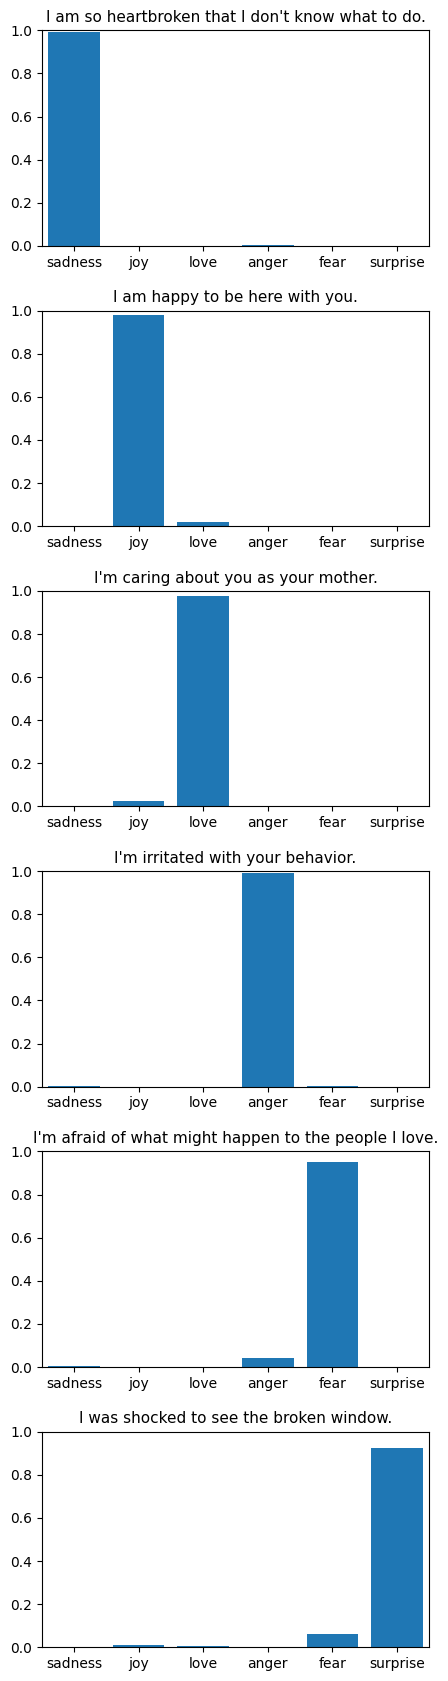

In [ ]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])

predictions = lstm_model.predict(input_ids, verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(5, 3.5*n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')